In [1]:
import os
import keras
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Add, Concatenate
from keras.layers import BatchNormalization, LayerNormalization

2024-02-11 01:00:36.479611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(dataset):
    data_path = {
        'train': './data/train_enc.tsv',
        'dev': './data/dev_enc.tsv',
        'test': './test_enc_unlabeled.tsv'
    }
    res = []
    if dataset in ['train','dev']:
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r').split('\t')
            x[0] = int(x[0])
            res.append(x)
    elif dataset == 'test':
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r')
            res.append(x)
    return res

In [3]:
train = load_data('train')
dev = load_data('dev')

In [4]:
train_labels = [x[0] for x in train]
train_texts = [x[1] for x in train]
dev_labels = [x[0] for x in dev]
dev_texts = [x[1] for x in dev]

In [5]:
print("Train size:", len(train_labels))
print("Dev size:", len(dev_labels))

Train size: 16220
Dev size: 2027


In [6]:
cv = CountVectorizer()
cv.fit(train_texts)
cv_vec = cv.transform(train_texts)
print(cv_vec.shape)

(16220, 17248)


In [7]:
# extract features using TF-IDF
tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,4),
    max_df=0.6,
    min_df=0.001
)
tfidf.fit(train_texts)

TfidfVectorizer(max_df=0.6, min_df=0.001, ngram_range=(1, 4))

In [8]:
tfidf_vec = tfidf.transform(train_texts)
print(tfidf_vec.shape)

(16220, 3967)


In [9]:
# build the feats_matrix
train_feats_matrix = tfidf.transform(train_texts).toarray()
dev_feats_matrix = tfidf.transform(dev_texts).toarray()
# convert labels to label_matrix
num_classes = 2
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels, num_classes=num_classes)
dev_label_matrix = keras.utils.to_categorical(dev_labels, num_classes=num_classes)

In [10]:
def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
   
    model = Sequential()
    
    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                model.add(Dense(hidden_size,
                                input_dim=input_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                                input_dim=hidden_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate, seed=0))
        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [11]:
histories = []

In [21]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=30, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5924 - loss: 0.7535 - val_accuracy: 0.7928 - val_loss: 0.4556
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7814 - loss: 0.4785 - val_accuracy: 0.8185 - val_loss: 0.4559
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8381 - loss: 0.3746 - val_accuracy: 0.8397 - val_loss: 0.4411
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8765 - loss: 0.2996 - val_accuracy: 0.8411 - val_loss: 0.4604
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8953 - loss: 0.2586 - val_accuracy: 0.8367 - val_loss: 0.5235
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9095 - loss: 0.2263 - val_accuracy: 0.8485 - val_loss: 0.5016
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9223 - loss: 0.1930 - val_accuracy: 0.8535 - val_loss: 0.5213
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9349 - loss: 0.1682 - val_accu

In [12]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=30, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 5s 9ms/step - loss: 0.6148 - accuracy: 0.6948 - val_loss: 0.4475 - val_accuracy: 0.7918
Epoch 2/30
507/507 [==============================] - 4s 8ms/step - loss: 0.4104 - accuracy: 0.8175 - val_loss: 0.4106 - val_accuracy: 0.8229
Epoch 3/30
507/507 [==============================] - 4s 8ms/step - loss: 0.3249 - accuracy: 0.8621 - val_loss: 0.3948 - val_accuracy: 0.8441
Epoch 4/30
507/507 [==============================] - 4s 8ms/step - loss: 0.2639 - accuracy: 0.8923 - val_loss: 0.3974 - val_accuracy: 0.8495
Epoch 5/30
507/507 [==============================] - 4s 8ms/step - loss: 0.2266 - accuracy: 0.9087 - val_loss: 0.4093 - val_accuracy: 0.8574
Epoch 6/30
507/507 [==============================] - 4s 8ms/step - loss: 0.1937 - accuracy: 0.9273 - val_loss: 0.4244 - val_accuracy: 0.8559
Epoch 7/30
507/507 [==============================] - 4s 8ms/step - loss: 0.1710 - accuracy: 0.9335 - val_loss: 0.4075 - val_accuracy: 0.8688
Epoch 

In [16]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=1, hidden_size=200, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=100, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/100
507/507 [==============================] - 2s 3ms/step - loss: 0.6856 - accuracy: 0.5801 - val_loss: 0.6768 - val_accuracy: 0.7010
Epoch 2/100
507/507 [==============================] - 1s 2ms/step - loss: 0.6702 - accuracy: 0.6819 - val_loss: 0.6646 - val_accuracy: 0.7079
Epoch 3/100
507/507 [==============================] - 1s 3ms/step - loss: 0.6565 - accuracy: 0.7102 - val_loss: 0.6511 - val_accuracy: 0.7277
Epoch 4/100
507/507 [==============================] - 1s 2ms/step - loss: 0.6441 - accuracy: 0.7276 - val_loss: 0.6400 - val_accuracy: 0.7277
Epoch 5/100
507/507 [==============================] - 2s 3ms/step - loss: 0.6331 - accuracy: 0.7394 - val_loss: 0.6302 - val_accuracy: 0.7316
Epoch 6/100
507/507 [==============================] - 1s 3ms/step - loss: 0.6230 - accuracy: 0.7473 - val_loss: 0.6215 - val_accuracy: 0.7346
Epoch 7/100
507/507 [==============================] - 1s 3ms/step - loss: 0.6136 - accuracy: 0.7523 - val_loss: 0.6138 - val_accuracy: 0.7361

In [18]:
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=200, batch_size=32, verbose=1,
                    callbacks=[checkpointer], initial_epoch=100)
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories[-1] = history

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 101/200
507/507 [==============================] - 2s 3ms/step - loss: 0.4051 - accuracy: 0.8417 - val_loss: 0.4540 - val_accuracy: 0.7982
Epoch 102/200
507/507 [==============================] - 1s 2ms/step - loss: 0.4044 - accuracy: 0.8417 - val_loss: 0.4530 - val_accuracy: 0.7997
Epoch 103/200
507/507 [==============================] - 1s 3ms/step - loss: 0.4035 - accuracy: 0.8426 - val_loss: 0.4521 - val_accuracy: 0.8022
Epoch 104/200
507/507 [==============================] - 1s 3ms/step - loss: 0.4027 - accuracy: 0.8425 - val_loss: 0.4522 - val_accuracy: 0.8007
Epoch 105/200
507/507 [==============================] - 1s 3ms/step - loss: 0.4020 - accuracy: 0.8446 - val_loss: 0.4517 - val_accuracy: 0.8022
Epoch 106/200
507/507 [==============================] - 1s 2ms/step - loss: 0.4013 - accuracy: 0.8435 - val_loss: 0.4509 - val_accuracy: 0.8037
Epoch 107/200
507/507 [==============================] - 1s 2ms/step - loss: 0.4005 - accuracy: 0.8443 - val_loss: 0.4510 - val_ac

In [19]:
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=1000, batch_size=32, verbose=1,
                    callbacks=[checkpointer], initial_epoch=200)
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories[-1] = history

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 201/1000
507/507 [==============================] - 2s 3ms/step - loss: 0.3574 - accuracy: 0.8630 - val_loss: 0.4288 - val_accuracy: 0.8155
Epoch 202/1000
507/507 [==============================] - 1s 2ms/step - loss: 0.3571 - accuracy: 0.8625 - val_loss: 0.4279 - val_accuracy: 0.8125
Epoch 203/1000
507/507 [==============================] - 2s 4ms/step - loss: 0.3567 - accuracy: 0.8631 - val_loss: 0.4274 - val_accuracy: 0.8155
Epoch 204/1000
507/507 [==============================] - 2s 4ms/step - loss: 0.3563 - accuracy: 0.8628 - val_loss: 0.4279 - val_accuracy: 0.8155
Epoch 205/1000
507/507 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8641 - val_loss: 0.4277 - val_accuracy: 0.8155
Epoch 206/1000
507/507 [==============================] - 1s 3ms/step - loss: 0.3557 - accuracy: 0.8636 - val_loss: 0.4271 - val_accuracy: 0.8155
Epoch 207/1000
507/507 [==============================] - 1s 3ms/step - loss: 0.3553 - accuracy: 0.8634 - val_loss: 0.4274 -

In [20]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.4)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=100, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/100
507/507 [==============================] - 5s 8ms/step - loss: 0.5833 - accuracy: 0.7155 - val_loss: 0.4433 - val_accuracy: 0.7977
Epoch 2/100
507/507 [==============================] - 4s 8ms/step - loss: 0.3735 - accuracy: 0.8405 - val_loss: 0.3909 - val_accuracy: 0.8357
Epoch 3/100
507/507 [==============================] - 4s 8ms/step - loss: 0.2847 - accuracy: 0.8848 - val_loss: 0.4365 - val_accuracy: 0.8446
Epoch 4/100
507/507 [==============================] - 5s 9ms/step - loss: 0.2215 - accuracy: 0.9129 - val_loss: 0.4648 - val_accuracy: 0.8323
Epoch 5/100
507/507 [==============================] - 4s 8ms/step - loss: 0.1898 - accuracy: 0.9268 - val_loss: 0.3952 - val_accuracy: 0.8629
Epoch 6/100
507/507 [==============================] - 4s 8ms/step - loss: 0.1536 - accuracy: 0.9436 - val_loss: 0.5393 - val_accuracy: 0.8214
Epoch 7/100
507/507 [==============================] - 4s 9ms/step - loss: 0.1425 - accuracy: 0.9498 - val_loss: 0.4331 - val_accuracy: 0.8648

In [21]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=300, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.4)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=100, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/100
507/507 [==============================] - 9s 15ms/step - loss: 0.6306 - accuracy: 0.7086 - val_loss: 0.4477 - val_accuracy: 0.8002
Epoch 2/100
507/507 [==============================] - 6s 12ms/step - loss: 0.3897 - accuracy: 0.8340 - val_loss: 0.4573 - val_accuracy: 0.8135
Epoch 3/100
507/507 [==============================] - 6s 11ms/step - loss: 0.2812 - accuracy: 0.8905 - val_loss: 0.4487 - val_accuracy: 0.8377
Epoch 4/100
507/507 [==============================] - 5s 11ms/step - loss: 0.2150 - accuracy: 0.9183 - val_loss: 0.4254 - val_accuracy: 0.8555
Epoch 5/100
507/507 [==============================] - 5s 10ms/step - loss: 0.1870 - accuracy: 0.9285 - val_loss: 0.4409 - val_accuracy: 0.8589
Epoch 6/100
507/507 [==============================] - 5s 9ms/step - loss: 0.1495 - accuracy: 0.9467 - val_loss: 0.5626 - val_accuracy: 0.8367
Epoch 7/100
507/507 [==============================] - 5s 10ms/step - loss: 0.1329 - accuracy: 0.9561 - val_loss: 0.5171 - val_accuracy: 

In [23]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=50, activation="relu",
                  batch_norm=True, layer_norm=True, dropout_rate=0.2)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=30, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix,
                           batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 8s 11ms/step - loss: 0.5233 - accuracy: 0.7420 - val_loss: 0.4280 - val_accuracy: 0.8041
Epoch 2/30
507/507 [==============================] - 5s 10ms/step - loss: 0.3350 - accuracy: 0.8593 - val_loss: 0.4115 - val_accuracy: 0.8234
Epoch 3/30
507/507 [==============================] - 5s 10ms/step - loss: 0.2552 - accuracy: 0.8971 - val_loss: 0.4416 - val_accuracy: 0.8303
Epoch 4/30
507/507 [==============================] - 5s 10ms/step - loss: 0.1972 - accuracy: 0.9250 - val_loss: 0.4345 - val_accuracy: 0.8407
Epoch 5/30
507/507 [==============================] - 5s 10ms/step - loss: 0.1707 - accuracy: 0.9377 - val_loss: 0.5016 - val_accuracy: 0.8273
Epoch 6/30
507/507 [==============================] - 6s 12ms/step - loss: 0.1426 - accuracy: 0.9501 - val_loss: 0.4632 - val_accuracy: 0.8500
Epoch 7/30
507/507 [==============================] - 7s 13ms/step - loss: 0.1274 - accuracy: 0.9578 - val_loss: 0.4666 - val_accuracy: 0.8481

In [26]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu", 
                  optimizer="Adam", learning_rate=0.001,
                  batch_norm=True, layer_norm=True, dropout_rate=0.2)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=30, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix, batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix, batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 13s 21ms/step - loss: 0.5174 - accuracy: 0.7614 - val_loss: 0.4056 - val_accuracy: 0.8273
Epoch 2/30
507/507 [==============================] - 13s 25ms/step - loss: 0.2439 - accuracy: 0.9064 - val_loss: 0.3630 - val_accuracy: 0.8619
Epoch 3/30
507/507 [==============================] - 14s 28ms/step - loss: 0.1564 - accuracy: 0.9494 - val_loss: 0.3698 - val_accuracy: 0.8614
Epoch 4/30
507/507 [==============================] - 14s 27ms/step - loss: 0.1196 - accuracy: 0.9644 - val_loss: 0.3948 - val_accuracy: 0.8683
Epoch 5/30
507/507 [==============================] - 12s 24ms/step - loss: 0.1033 - accuracy: 0.9689 - val_loss: 0.4185 - val_accuracy: 0.8688
Epoch 6/30
507/507 [==============================] - 13s 26ms/step - loss: 0.0869 - accuracy: 0.9730 - val_loss: 0.4433 - val_accuracy: 0.8614
Epoch 7/30
507/507 [==============================] - 13s 26ms/step - loss: 0.0797 - accuracy: 0.9749 - val_loss: 0.4534 - val_accuracy:

In [31]:
num_classes = 2
model = build_MLP(input_size=train_feats_matrix.shape[1], output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu", 
                  optimizer="Adam", learning_rate=0.001,
                  batch_norm=True, layer_norm=True, dropout_rate=0.5,
                  l2_reg=0.01)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="./models/mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=30, batch_size=32, verbose=1,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix, batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix, batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 11s 19ms/step - loss: 1.4470 - accuracy: 0.7326 - val_loss: 1.0500 - val_accuracy: 0.7810
Epoch 2/30
507/507 [==============================] - 8s 16ms/step - loss: 0.9673 - accuracy: 0.7978 - val_loss: 0.9446 - val_accuracy: 0.7987
Epoch 3/30
507/507 [==============================] - 8s 15ms/step - loss: 0.9550 - accuracy: 0.7978 - val_loss: 0.9474 - val_accuracy: 0.8027
Epoch 4/30
507/507 [==============================] - 9s 18ms/step - loss: 0.9549 - accuracy: 0.7986 - val_loss: 0.9341 - val_accuracy: 0.7977
Epoch 5/30
507/507 [==============================] - 8s 16ms/step - loss: 0.9541 - accuracy: 0.7938 - val_loss: 0.9876 - val_accuracy: 0.7701
Epoch 6/30
507/507 [==============================] - 7s 14ms/step - loss: 0.9557 - accuracy: 0.8036 - val_loss: 0.9861 - val_accuracy: 0.7982
Epoch 7/30
507/507 [==============================] - 8s 15ms/step - loss: 0.9574 - accuracy: 0.7985 - val_loss: 0.9695 - val_accuracy: 0.797

In [33]:
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(dev_feats_matrix, dev_label_matrix),
                    epochs=60, batch_size=32, verbose=1, initial_epoch=30,
                    callbacks=[checkpointer])
model = keras.models.load_model("./models/mlp.keras",
                                custom_objects={"LayerNormalization": LayerNormalization})

train_score = model.evaluate(train_feats_matrix, train_label_matrix, batch_size=32)
dev_score = model.evaluate(dev_feats_matrix, dev_label_matrix, batch_size=32)

histories.append(history)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 31/60
507/507 [==============================] - 11s 20ms/step - loss: 0.8877 - accuracy: 0.8142 - val_loss: 0.9202 - val_accuracy: 0.7967
Epoch 32/60
507/507 [==============================] - 8s 17ms/step - loss: 0.8856 - accuracy: 0.8155 - val_loss: 0.9201 - val_accuracy: 0.8170
Epoch 33/60
507/507 [==============================] - 12s 24ms/step - loss: 0.9050 - accuracy: 0.8136 - val_loss: 0.9343 - val_accuracy: 0.7992
Epoch 34/60
507/507 [==============================] - 10s 20ms/step - loss: 0.8901 - accuracy: 0.8156 - val_loss: 0.9204 - val_accuracy: 0.8066
Epoch 35/60
507/507 [==============================] - 8s 15ms/step - loss: 0.8955 - accuracy: 0.8159 - val_loss: 0.8942 - val_accuracy: 0.8125
Epoch 36/60
507/507 [==============================] - 10s 19ms/step - loss: 0.8938 - accuracy: 0.8195 - val_loss: 0.9808 - val_accuracy: 0.7711
Epoch 37/60
507/507 [==============================] - 9s 17ms/step - loss: 0.8892 - accuracy: 0.8168 - val_loss: 0.9045 - val_accur

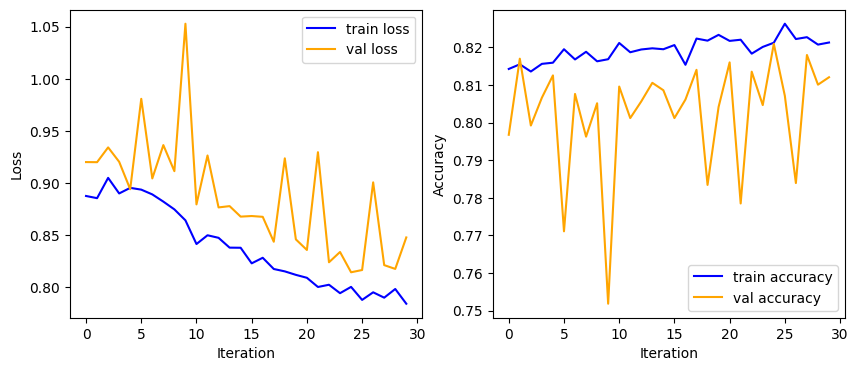

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss", color="blue")
plt.plot(history.history["val_loss"], label="val loss", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="val accuracy", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()